# Deep Support Vector Data Description

From Ruff 2018. The architecture and hyperparameters values are directly taken from the paper as a first test.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

print(tf.__version__)

# # DRIVE
# from google.colab import drive
# drive.mount('/content/gdrive')
# import sys
# sys.path.append('/content/gdrive/My Drive/BACMMAN_DISTNET/')

from uad.callbacks.metrics import AUCCallback, PrecisionRecallCallback
from uad.models.variational_autoencoder import ConvolutionalVAE
from uad.decision.reconstruction import binarize_set
from uad.diagnostic.visualisation import plot_tSNE
from uad.diagnostic.metrics import compute_ROC, compute_AUC, plot_ROC

!nvidia-smi

2.2.0


Using TensorFlow backend.
'nvidia-smi' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


## Import data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

interest_digit = 1

# validation set
x_val, y_val_bin = x_train[-1000:], binarize_set(y_train[-1000:], interest=interest_digit)

# train set sorted by digits: digits_train[i] = x_train elements where y_train == i
digits_train = np.array([x_train[np.where(y_train[:-1000] == i)] for i in range(10)])

labels_bin = binarize_set(y_train, interest=interest_digit)
x_train_bin, y_train_bin = digits_train[interest_digit][:-1000], y_train[np.where(y_train[:-1000] == interest_digit)][:-1000]
y_test_bin = binarize_set(y_test, interest=interest_digit)

print(x_train_bin.shape, y_train_bin.shape, x_val.shape, y_val_bin.shape)

(5640, 28, 28, 1) (5640,) (1000, 28, 28, 1) (1000,)


In [32]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import Constraint
from uad.decision.deep_svdd import anomaly_score_from_predictions, is_anormal
from uad.diagnostic.metrics import binarize_set

def anomaly_score_from_predictions(model, predictions):
    """
    Compute the anomaly score from preidctions of model. Those predictions are considered
    to vectors
    # TODO: implement for matrix or 3-tensors predictions
    :param model: Model that has a CENTER attribute
    :param predictions: Model predictions
    :return:
    """
    if len(predictions.shape) > 1:  # batch of vectors along the first axis
        return tf.norm(model.CENTER - predictions, axis=-1) ** 2
    else:  # single vector, tf.norm parameter axis=None
        return tf.norm(model.CENTER - predictions) ** 2
    
    
def anomaly_score_from_images(model, images):
    """
    Compute the anomaly score output by a model from a single image or a batch of images
    :param model: Deep SVDD model that possedes a self.CENTRE attribute
    :param images: either single image or batch of images
    :param n_images_axis: (int) Number of axis of the images/batch of images. If a single image
    is a 3-tensor (tf default format: (x, y, channels)) input 3, if images are matrices (x, y)
    input 2.
    :return:
    """
    predictions = model.predict(images)
    return anomaly_score_from_predictions(model, predictions)


class DeepSVDD(Model):
    """
    Support Vector Data Description neural network. Trained on original data and learns a dense embedding while
    trained on the objective function.
    """

    def __init__(self, n_filters=(8, 4), dense_shape=32, LAMBDA=1e-6, **kwargs):
        """
        If inputs is None and outputs is None: builds a DeepSVDD network with a LeNet architecture as used in Ruff 2018
        Else give input and outputs to build a model via subclassing
        :param n_filters: # filters for each convolution. Tuple length must match the number of blocks
        :param dims: input shape
        :param dense_shape: number of units of the final dense layer
        :param LAMBDA: factor in front of the weight decay loss
        :param kwargs:
        """
        super(DeepSVDD, self).__init__(**kwargs)
        self.CENTER = tf.Variable(initial_value=np.ones(dense_shape), dtype=tf.float32)  # center of the same size as output
        self.RADIUS = 0
        self.LAMBDA = tf.constant(LAMBDA, dtype=tf.float32)
        
        self.c1 = layers.Conv2D(filters=n_filters[0], kernel_size=5, strides=(1, 1), kernel_regularizer=l2(self.LAMBDA),
                                bias_regularizer=l2(self.LAMBDA), padding="same", name=f"conv_1")
        self.a1 = layers.LeakyReLU(alpha=0.1, name=f"activation_1")
        self.mp1 = layers.MaxPooling2D((2, 2), name=f"max_pooling_1")
        self.c2 = layers.Conv2D(filters=n_filters[1], kernel_size=5, strides=(1, 1), kernel_regularizer=l2(self.LAMBDA),
                                bias_regularizer=l2(self.LAMBDA), padding="same", name=f"conv_2")
        self.a2 = layers.LeakyReLU(alpha=0.1, name=f"activation_2")
        self.mp2 = layers.MaxPooling2D((2, 2), name=f"max_pooling_2")
        self.f2 = layers.Flatten()
        self.outputs = layers.Dense(dense_shape, kernel_regularizer=l2(self.LAMBDA), bias_regularizer=l2(self.LAMBDA))

    def set_center(self, new_center):
        self.CENTER = new_center
        tf.print(f"Hypersphere center coordinates: {self.CENTER}")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape: 
            predictions = self(data)
            distances_to_center = tf.norm(predictions - self.CENTER, axis=-1)
            self.RADIUS = tf.reduce_max(distances_to_center)
            centripetal_loss = tf.reduce_mean(distances_to_center ** 2)
            weight_decay = tf.math.reduce_sum(self.losses)
            total_loss = centripetal_loss + self.LAMBDA * weight_decay
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "total_loss": total_loss,
            "centripetal_loss": centripetal_loss,
            "weight_decay": weight_decay
        }

    def call(self, inputs):
        x = self.c1(inputs)
        x = self.a1(x)
        x = self.mp1(x)

        x = self.c2(x)
        x = self.a2(x)
        x = self.mp2(x)
        x = self.f2(x)
        
        return self.outputs(x)

    def score_samples(self, data):
        """
        Returns the anomaly scores for data (name of the method inspired from the sklearn
        interface)
        :param data: image or batch of images
        :return: anomaly scores
        """
        return (anomaly_score_from_images(self, data)).numpy()
    
    def is_anormal(self, data, im_threshold=0):
        predictions = self.predict(data)
        return binarize_set(np.sum((predictions - self.CENTER) ** 2, axis=-1) > im_threshold)
    
    def compute_ROC(self, y_true, y_score):
        return roc_curve(y_true, y_score)
    
    def evaluate_on_all(self, x_train, x_test, y_test, n_classes=10, epochs=30, **params):
        """
        Compute AUC score for the training on each class of the dataset
        """
        auc_scores = []
        for k in range(n_classes):
            print(f"Digit {k}, # Training examples: {x_train[k].shape[0]}")
            model = DeepSVDD(**params)
            model.compile(optimizer=tf.keras.optimizers.Adam())
            model.fit(x_train[k], epochs=epochs, batch_size=128)
            y_score = model.score_samples(x_test)
            y_true = binarize_set(y_test, interest=0)
            fpr, tpr, _ = self.compute_ROC(y_true, y_score)
            auc = compute_AUC(fpr, tpr)
            auc_scores.append(auc)

        return np.array(auc_scores)

In [33]:
svdd = DeepSVDD()
svdd.compile(optimizer=tf.keras.optimizers.Adam())

history = svdd.fit(x_train_bin, epochs=1, batch_size=64)

89/89 [==============================] - 2s 25ms/step - total_loss: 3.9347 - centripetal_loss: 3.9347 - weight_decay: 6.4434e-05


In [34]:
predictions = svdd.predict(x_test)
center = np.reshape(svdd.CENTER.numpy(), (1, 32))
y_pred = svdd.is_anormal(x_test, im_threshold=0.5)

## Plot ROC

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x142a80ec3c8>)

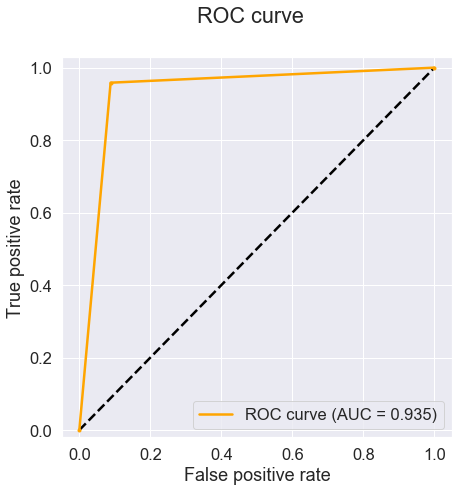

In [29]:
from uad.diagnostic.metrics import plot_ROC

fprs, tprs, _ = svdd.compute_ROC(y_test_bin, y_pred)

plot_ROC(fprs, tprs)

## t-SNE visualisation

In [20]:
print(svdd.score_samples(x_test[:10]))
print(y_test_bin[:10])

# --> Scores seem to be compatible with normal/abnormal

[0.5050533  2.6626947  0.4059295  5.519415   1.4837837  0.12223694
 1.4890852  2.25057    1.5265359  1.483836  ]
[1 1 0 1 1 0 1 1 1 1]


In [21]:
plot_tSNE(predictions, y_test_bin, plot_center=center, axis=0)

t-SNE inputs shape: (10001, 32)


KeyboardInterrupt: 

## Plot prediction norms distribution

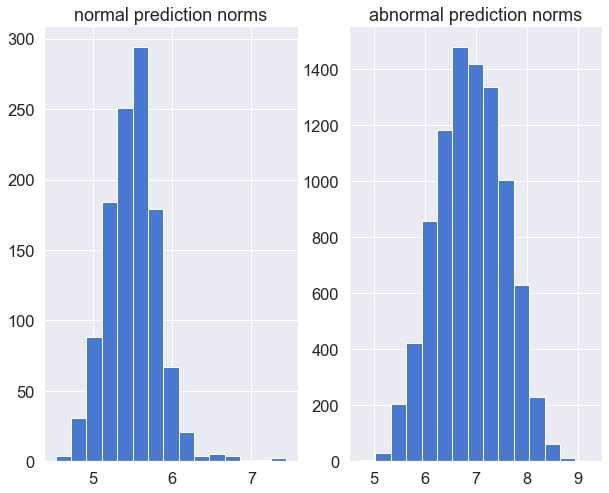

In [22]:
normal_norms, abnormal_norms = [], []

for pred, lab in zip(predictions, y_test_bin):
    n = tf.norm(pred)
    if lab == 0:
        normal_norms.append(n)
    else:
        abnormal_norms.append(n)
        
normal_norms = np.array(normal_norms)
abnormal_norms = np.array(abnormal_norms)

fir, axis = plt.subplots(1, 2, figsize=(10, 8))
for ax, n, title in zip(axis.flatten(), [normal_norms, abnormal_norms], ["normal prediction norms", "abnormal prediction norms"]):
    ax.hist(n, bins=15)
    ax.set_title(title)


## Evaluate on all classes (AUC score)

In [35]:
from uad.diagnostic.metrics import compute_AUC_on_all

scores = svdd.evaluate_on_all(digits_train, x_test, y_test, n_classes=10, epochs=1)
for i, elt in enumerate(scores):
    print(f"Digit: {i}: AUC = {elt}")

Digit 0, # Training examples: 5825
46/46 [==============================] - 2s 37ms/step - total_loss: 5.9245 - centripetal_loss: 5.9245 - weight_decay: 6.3131e-05
Digit 1, # Training examples: 6640
52/52 [==============================] - 2s 37ms/step - total_loss: 8.3022 - centripetal_loss: 8.3022 - weight_decay: 6.4859e-05
Digit 2, # Training examples: 5853
46/46 [==============================] - 2s 37ms/step - total_loss: 12.5920 - centripetal_loss: 12.5920 - weight_decay: 6.2518e-05
Digit 3, # Training examples: 6028
48/48 [==============================] - 2s 39ms/step - total_loss: 9.8449 - centripetal_loss: 9.8449 - weight_decay: 6.2333e-05
Digit 4, # Training examples: 5746


KeyboardInterrupt: 